In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==============================================================================
# --- 1. SETUP and LOAD DATA ---
# ==============================================================================
# Define paths
USER_HOME = "/content/drive/MyDrive/Bren_code/My_work/"
BASE_PATH = os.path.join(USER_HOME, "SMACS_Analysis/")
catalog_path = os.path.join(BASE_PATH, "smacs_line_flux_catalog.csv")

print(f"Loading catalog from: {catalog_path}")
try:
    df = pd.read_csv(catalog_path)
    print(f"Successfully loaded catalog with {len(df)} entries.")
except FileNotFoundError:
    print(f"ERROR: Catalog file not found at {catalog_path}")
    df = pd.DataFrame() # Create empty dataframe to prevent crash

Loading catalog from: /content/drive/MyDrive/Bren_code/My_work/SMACS_Analysis/smacs_line_flux_catalog.csv
Successfully loaded catalog with 81 entries.


In [3]:
if not df.empty:
    print("\n--- Calculating Common Diagnostic Ratios ---")

    # Start with the galaxy identifiers
    ratios_df = df[['galaxy_id', 'redshift']].copy()

    # Define the ratios we want to calculate as a dictionary
    # Key: new column name, Value: (numerator column(s), denominator column(s))
    ratio_definitions = {
        'Balmer_Decrement': ('Halpha_flux', 'Hbeta_flux'),
        'O3_Hb': ('OIII5007_flux', 'Hbeta_flux'),
        'N2_Ha': ('NII6583_flux', 'Halpha_flux'),
        'S2_Ha': (['SII6716_flux', 'SII6731_flux'], 'Halpha_flux'),
        'Ne3_O2': ('NeIII3869_flux', 'OII3727_flux'),
        'O3_Ratio_Check': ('OIII5007_flux', 'OIII4959_flux'),
        'S2_Density_Ratio': ('SII6716_flux', 'SII6731_flux')
    }

    for name, (num, den) in ratio_definitions.items():
        # Check if all required columns exist in the main dataframe
        num_cols = num if isinstance(num, list) else [num]
        den_cols = den if isinstance(den, list) else [den]
        required_cols = num_cols + den_cols

        if not all(col in df.columns for col in required_cols):
            print(f"  - Skipping ratio '{name}': one or more required columns not found in catalog.")
            continue

        # Calculate numerator and denominator safely, summing if numerator is a list
        numerator = df[num_cols].sum(axis=1) if isinstance(num, list) else df[num]
        denominator = df[den_cols].sum(axis=1) if isinstance(den, list) else df[den]

        # Calculate the ratio where denominator is not zero or NaN
        # The result will be NaN otherwise. This prevents division errors.
        with np.errstate(divide='ignore', invalid='ignore'):
          ratio_col = numerator / denominator

        # Add the linear and log10 ratios to our new dataframe
        ratios_df[name] = ratio_col
        # For log ratios, only calculate where ratio is positive
        with np.errstate(divide='ignore', invalid='ignore'):
            ratios_df[f'log_{name}'] = np.log10(ratio_col.where(ratio_col > 0))

    # Display the full table of calculated ratios
    print("\n--- Calculated Line Ratios (NaN where not possible) ---")
    # Use to_string() to ensure pandas doesn't truncate the output
    print(ratios_df.to_string())

    # --- Save the ratios to a CSV file ---
    output_filename = os.path.join(BASE_PATH, "galaxy_line_ratios.csv")
    try:
        # Use index=False to avoid writing the DataFrame index as a column
        ratios_df.to_csv(output_filename, index=False)
        print(f"\n✅ Successfully saved ratios to '{output_filename}'")
    except Exception as e:
        print(f"\n❌ Error saving file: {e}")


--- Calculating Common Diagnostic Ratios ---

--- Calculated Line Ratios (NaN where not possible) ---
    galaxy_id  redshift  Balmer_Decrement  log_Balmer_Decrement     O3_Hb  log_O3_Hb     N2_Ha  log_N2_Ha         S2_Ha  log_S2_Ha    Ne3_O2  log_Ne3_O2  O3_Ratio_Check  log_O3_Ratio_Check  S2_Density_Ratio  log_S2_Density_Ratio
0          -1    2.4040               NaN                   NaN       NaN        NaN       NaN        NaN  9.330338e-05  -4.030103       NaN         NaN             NaN                 NaN               NaN                   NaN
1         -12    3.1771               NaN                   NaN       NaN        NaN  0.106143  -0.974110  0.000000e+00        NaN       NaN         NaN             NaN                 NaN               NaN                   NaN
2         -13    3.0882               NaN                   NaN       NaN        NaN       NaN        NaN           NaN        NaN       NaN         NaN             NaN                 NaN               NaN    


--- Generating N2-BPT Diagram ---
Found 2 galaxies with all four lines for the N2-BPT diagram.


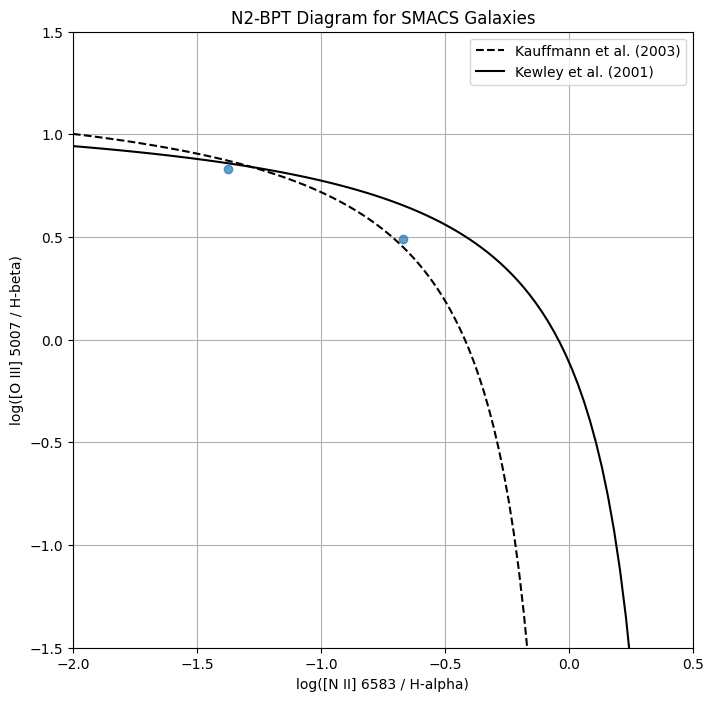

In [4]:
# ==============================================================================
# --- 2. N2-BPT DIAGRAM ([OIII]/H-beta vs [NII]/H-alpha) ---
# ==============================================================================
print("\n--- Generating N2-BPT Diagram ---")

# Define the lines needed for this diagram
n2_bpt_required_lines = [
    'OIII5007_flux',
    'Hbeta_flux',
    'NII6583_flux',
    'Halpha_flux'
]

# Drop all rows where ANY of the required lines was not detected (i.e., is NaN)
n2_bpt_sample = df.dropna(subset=n2_bpt_required_lines).copy()
print(f"Found {len(n2_bpt_sample)} galaxies with all four lines for the N2-BPT diagram.")

if not n2_bpt_sample.empty:
    # --- Calculate Ratios ---
    # We use .copy() above to avoid SettingWithCopyWarning
    n2_bpt_sample['log_oiii_hb'] = np.log10(n2_bpt_sample['OIII5007_flux'] / n2_bpt_sample['Hbeta_flux'])
    n2_bpt_sample['log_nii_ha'] = np.log10(n2_bpt_sample['NII6583_flux'] / n2_bpt_sample['Halpha_flux'])

    # --- Create the Plot ---
    plt.figure(figsize=(8, 8))
    plt.scatter(n2_bpt_sample['log_nii_ha'], n2_bpt_sample['log_oiii_hb'], alpha=0.7, zorder=5)

    # --- Add Scientific Demarcation Lines ---
    # Kauffmann et al. (2003) - separates pure star-formation
    kauffmann_x = np.linspace(-2.0, 0.0, 100)
    kauffmann_y = 0.61 / (kauffmann_x - 0.05) + 1.3
    plt.plot(kauffmann_x, kauffmann_y, 'k--', label='Kauffmann et al. (2003)')

    # Kewley et al. (2001) - separates "extreme" starbursts from AGN
    kewley_x = np.linspace(-2.0, 0.4, 100)
    kewley_y = 0.61 / (kewley_x - 0.47) + 1.19
    plt.plot(kewley_x, kewley_y, 'k-', label='Kewley et al. (2001)')

    # --- Final Touches ---
    plt.xlabel('log([N II] 6583 / H-alpha)')
    plt.ylabel('log([O III] 5007 / H-beta)')
    plt.title('N2-BPT Diagram for SMACS Galaxies')
    plt.xlim(-2.0, 0.5)
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# ==============================================================================
# --- 3. OHNO DIAGRAM ---
# ==============================================================================
print("\n--- Generating OHNO Diagram ---")

# Define the lines needed for this diagram
# Note: We need both [S II] lines
s2_bpt_required_lines = [
    'OIII5007_flux',
    'Hbeta_flux',
    'NeIII3869_flux',
    'OII3727_flux'
]

# Drop rows where any required line is NaN
s2_bpt_sample = df.dropna(subset=s2_bpt_required_lines).copy()
print(f"Found {len(s2_bpt_sample)} galaxies with all lines for the OHNO diagram.")

if not s2_bpt_sample.empty:
    # --- Calculate Ratios ---
    s2_bpt_sample['log_oiii_hb'] = np.log10(s2_bpt_sample['OIII5007_flux'] / s2_bpt_sample['Hbeta_flux'])
    s2_bpt_sample['log_neiii_oii'] = np.log10(s2_bpt_sample['NeIII3869_flux'] / s2_bpt_sample['OII3727_flux'])

    # --- Create the Plot ---
    plt.figure(figsize=(8, 8))
    plt.scatter(s2_bpt_sample['log_neiii_oii'], s2_bpt_sample['log_oiii_hb'], alpha=0.7, zorder=5)

    # --- Add Scientific Demarcation Lines (Kewley et al. 2006) ---
    # AGN / Star-Forming division
    kewley_s2_agn_x = np.linspace(-3.0, 0.3, 100)
    kewley_s2_agn_y = 0.72 / (kewley_s2_agn_x - 0.32) + 1.3
    plt.plot(kewley_s2_agn_x, kewley_s2_agn_y, 'k-', label='Kewley et al. (2006) AGN')

    # Seyfert / LINER division
    kewley_s2_liner_x = np.linspace(-0.31, 1.0, 100)
    kewley_s2_liner_y = 1.89 * kewley_s2_liner_x + 0.76
    plt.plot(kewley_s2_liner_x, kewley_s2_liner_y, 'k--', label='Kewley et al. (2006) LINER')

    # --- Final Touches ---
    plt.xlabel('log([Ne III] 3869 / [O II] 3727)')
    plt.ylabel('log([O III] 5007 / H-beta)')
    plt.title('S2-BPT Diagram for SMACS Galaxies')
    plt.xlim(-1.5, 0.5)
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.grid(True)
    plt.show()


--- Generating OHNO Diagram ---
Found 0 galaxies with all lines for the OHNO diagram.
